In [45]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [46]:
import numpy as np
import data_load
import train_util
import train_tl
from importlib import reload

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import datetime
import time


# training data
image_size = 224
#labels = pd.read_csv("data/fgvc7/train.csv")
image_dir = "data/unlabeled"


tf.random.set_seed(1234)
np.random.seed(seed=1234)

In [124]:
## Based on https://keras.io/examples/vision/grad_cam/

import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def showGradCamv2(model, img_array, true_label, last_conv_layer_name = "top_conv",save_path = r"data/archive/grad_cam_test1.jpg"):

    #img_array = get_img_array(img_path, (image_size,image_size))
    classifier_layer_name = [model.layers[-2].name, model.layers[-1].name]
    classes = ['healthy', 'multiple_diseases', 'rust', 'scab']
    # Print what the top predicted class is
    preds = model.predict(img_array)
    for i, img in enumerate(img_array):
        
        #print(preds)
        print("Predicted:", classes[np.argmax(preds[i])], " True: ", classes[true_label[i]])

        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name, classifier_layer_name)

        # We raescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # We use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # We use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # We create an image with RGB colorized heatmap
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * 0.7 + img * 0.5
        merged_img = np.hstack((img, superimposed_img))
        superimposed_img = keras.preprocessing.image.array_to_img(merged_img)


        # Save the superimposed image
        superimposed_img.save(save_path)

        # Display Grad CAM
        display(Image(save_path))

In [54]:
#Load model
model = model2


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
classes = ['healthy', 'multiple_diseases', 'rust', 'scab']

data_x, data_y  = train_tl.load_data() 
x_train, x_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.30, random_state=42)

data_y_pred = np.argmax(model.predict(data_x), axis=1)
data_y_true = np.argmax(data_y, axis=1)

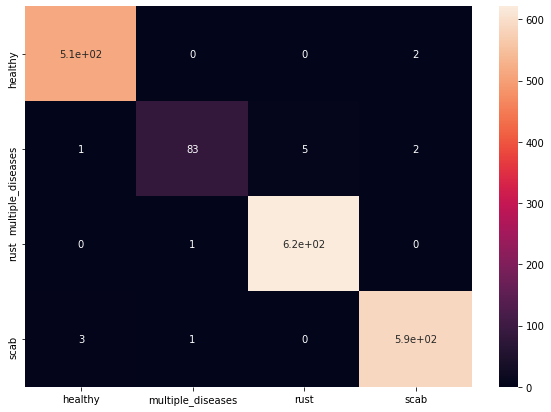

In [72]:
mat = confusion_matrix(data_y_true, data_y_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

Predicted: multiple_diseases  True:  rust


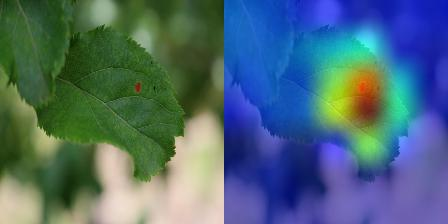

Predicted: scab  True:  multiple_diseases


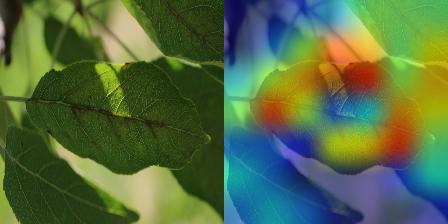

Predicted: healthy  True:  scab


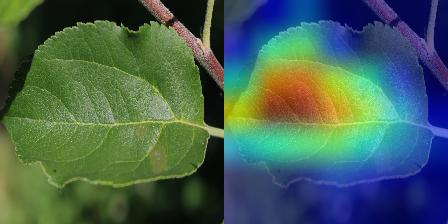

Predicted: scab  True:  multiple_diseases


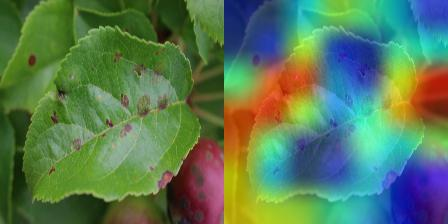

Predicted: rust  True:  multiple_diseases


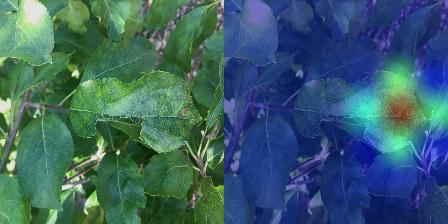

Predicted: rust  True:  multiple_diseases


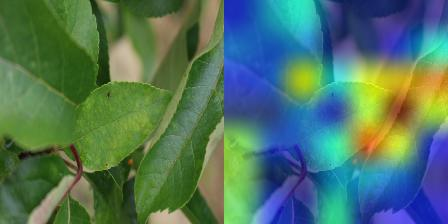

Predicted: rust  True:  multiple_diseases


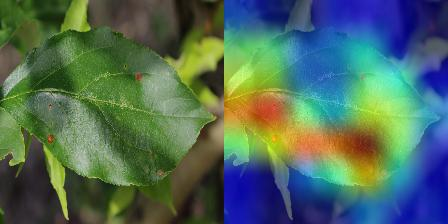

Predicted: scab  True:  healthy


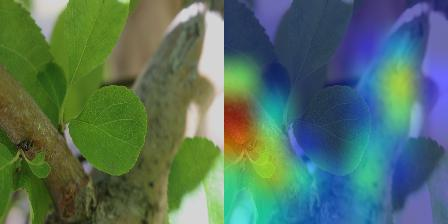

Predicted: rust  True:  multiple_diseases


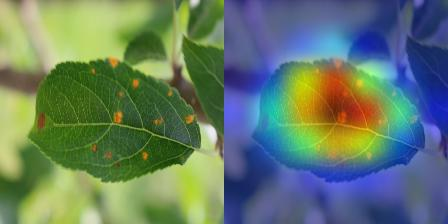

Predicted: healthy  True:  multiple_diseases


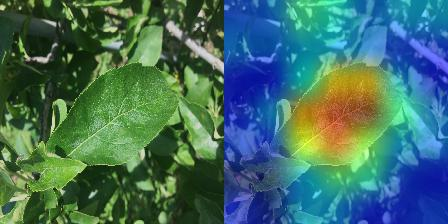

Predicted: healthy  True:  scab


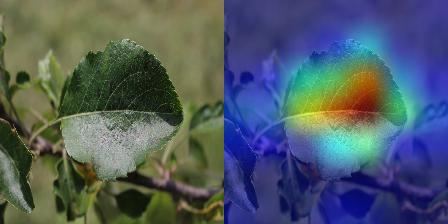

Predicted: scab  True:  healthy


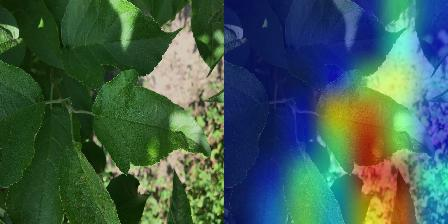

Predicted: multiple_diseases  True:  scab


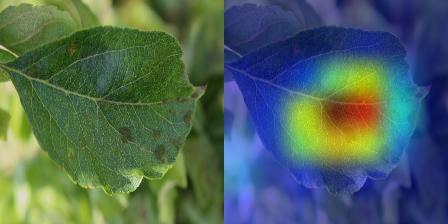

Predicted: healthy  True:  scab


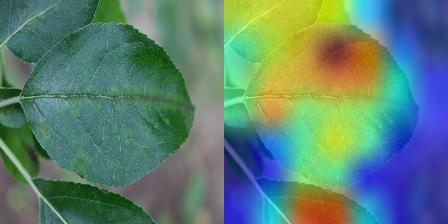

Predicted: rust  True:  multiple_diseases


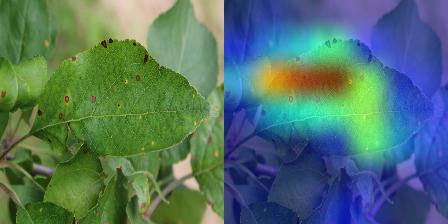

In [125]:
errors = data_y_pred != data_y_true
error_images = data_x[errors]
error_labels = data_y_true[errors]

showGradCamv2(model, error_images, error_labels)

## Grad-Cam test

Predicted: scab


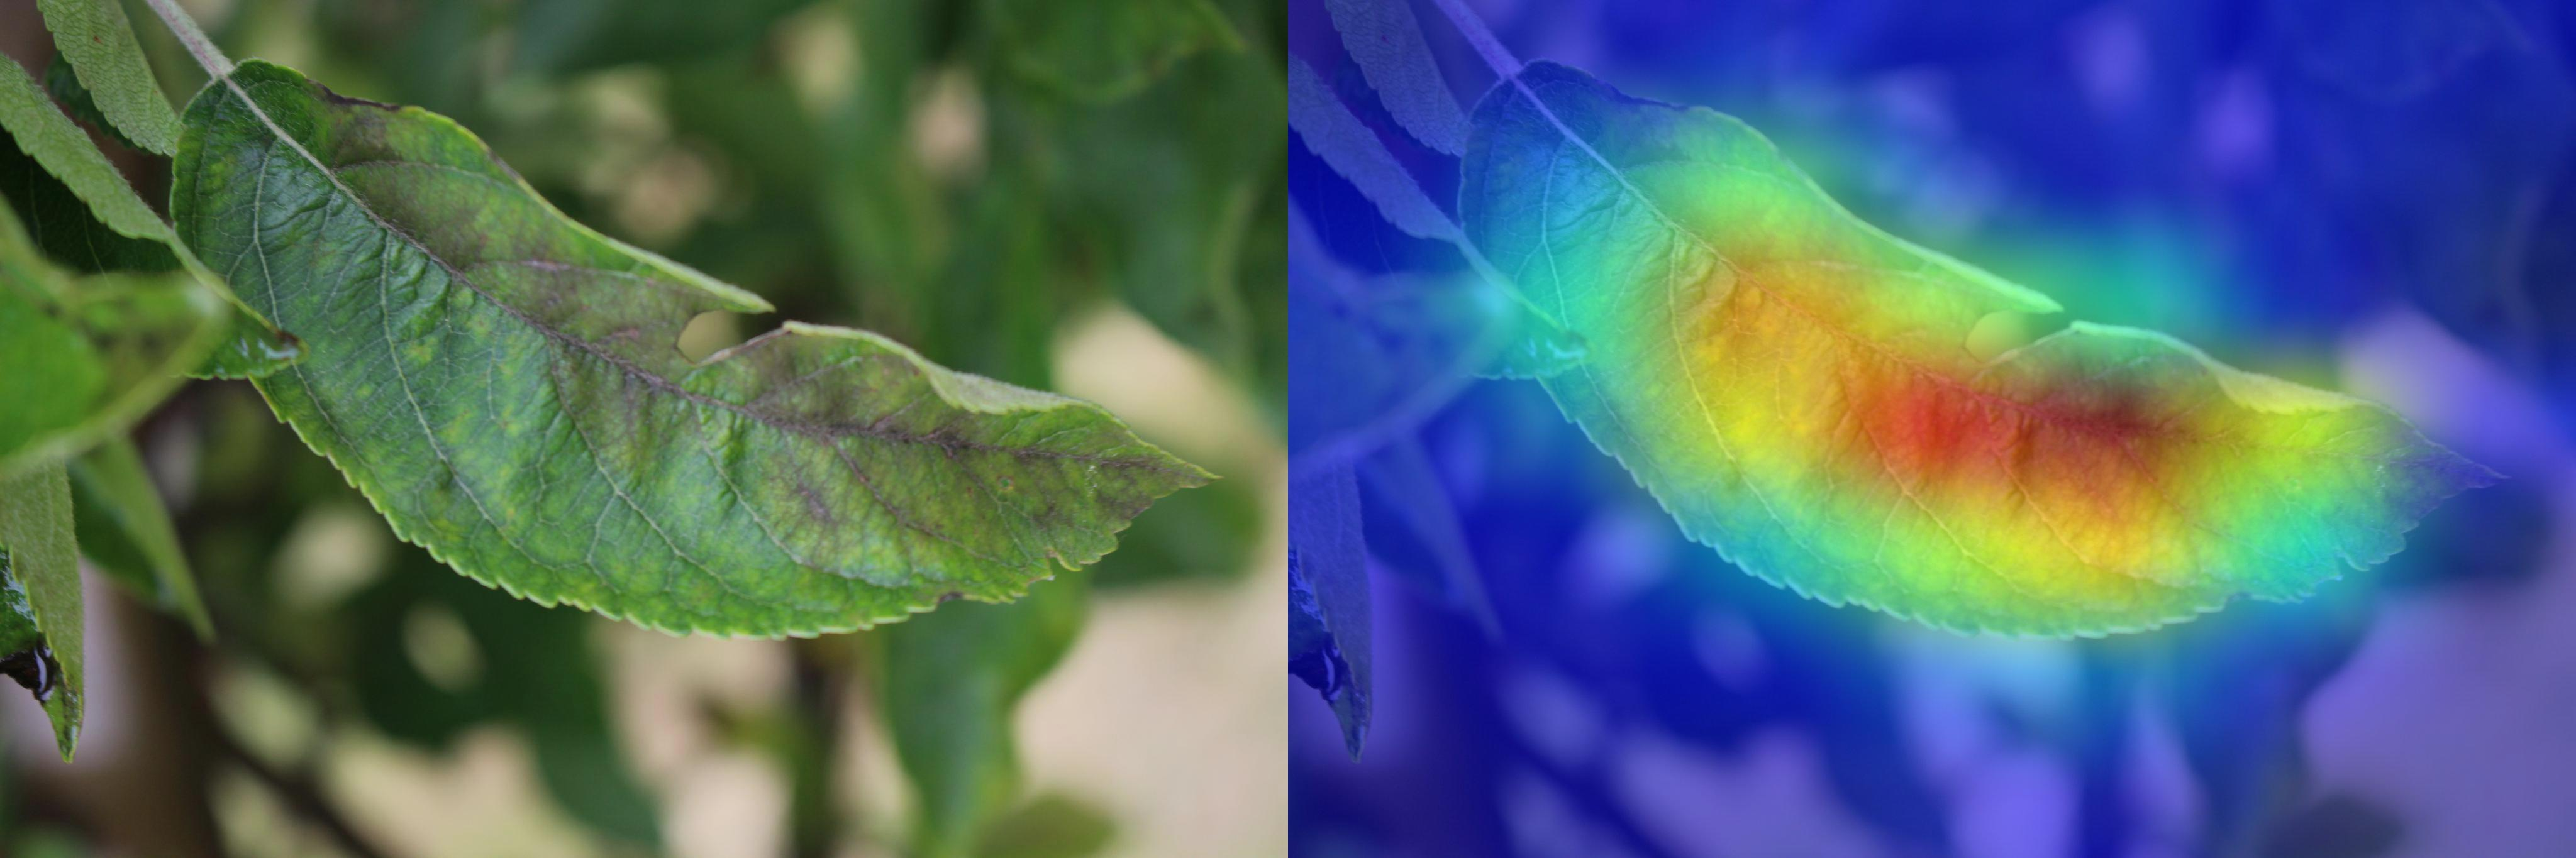

In [101]:
import grad_cam
grad_cam.showGradCam(model2, img_path = r"F:\notebooks\capstone\data\fgvc7\images\Test_2.jpg")

Predicted: healthy


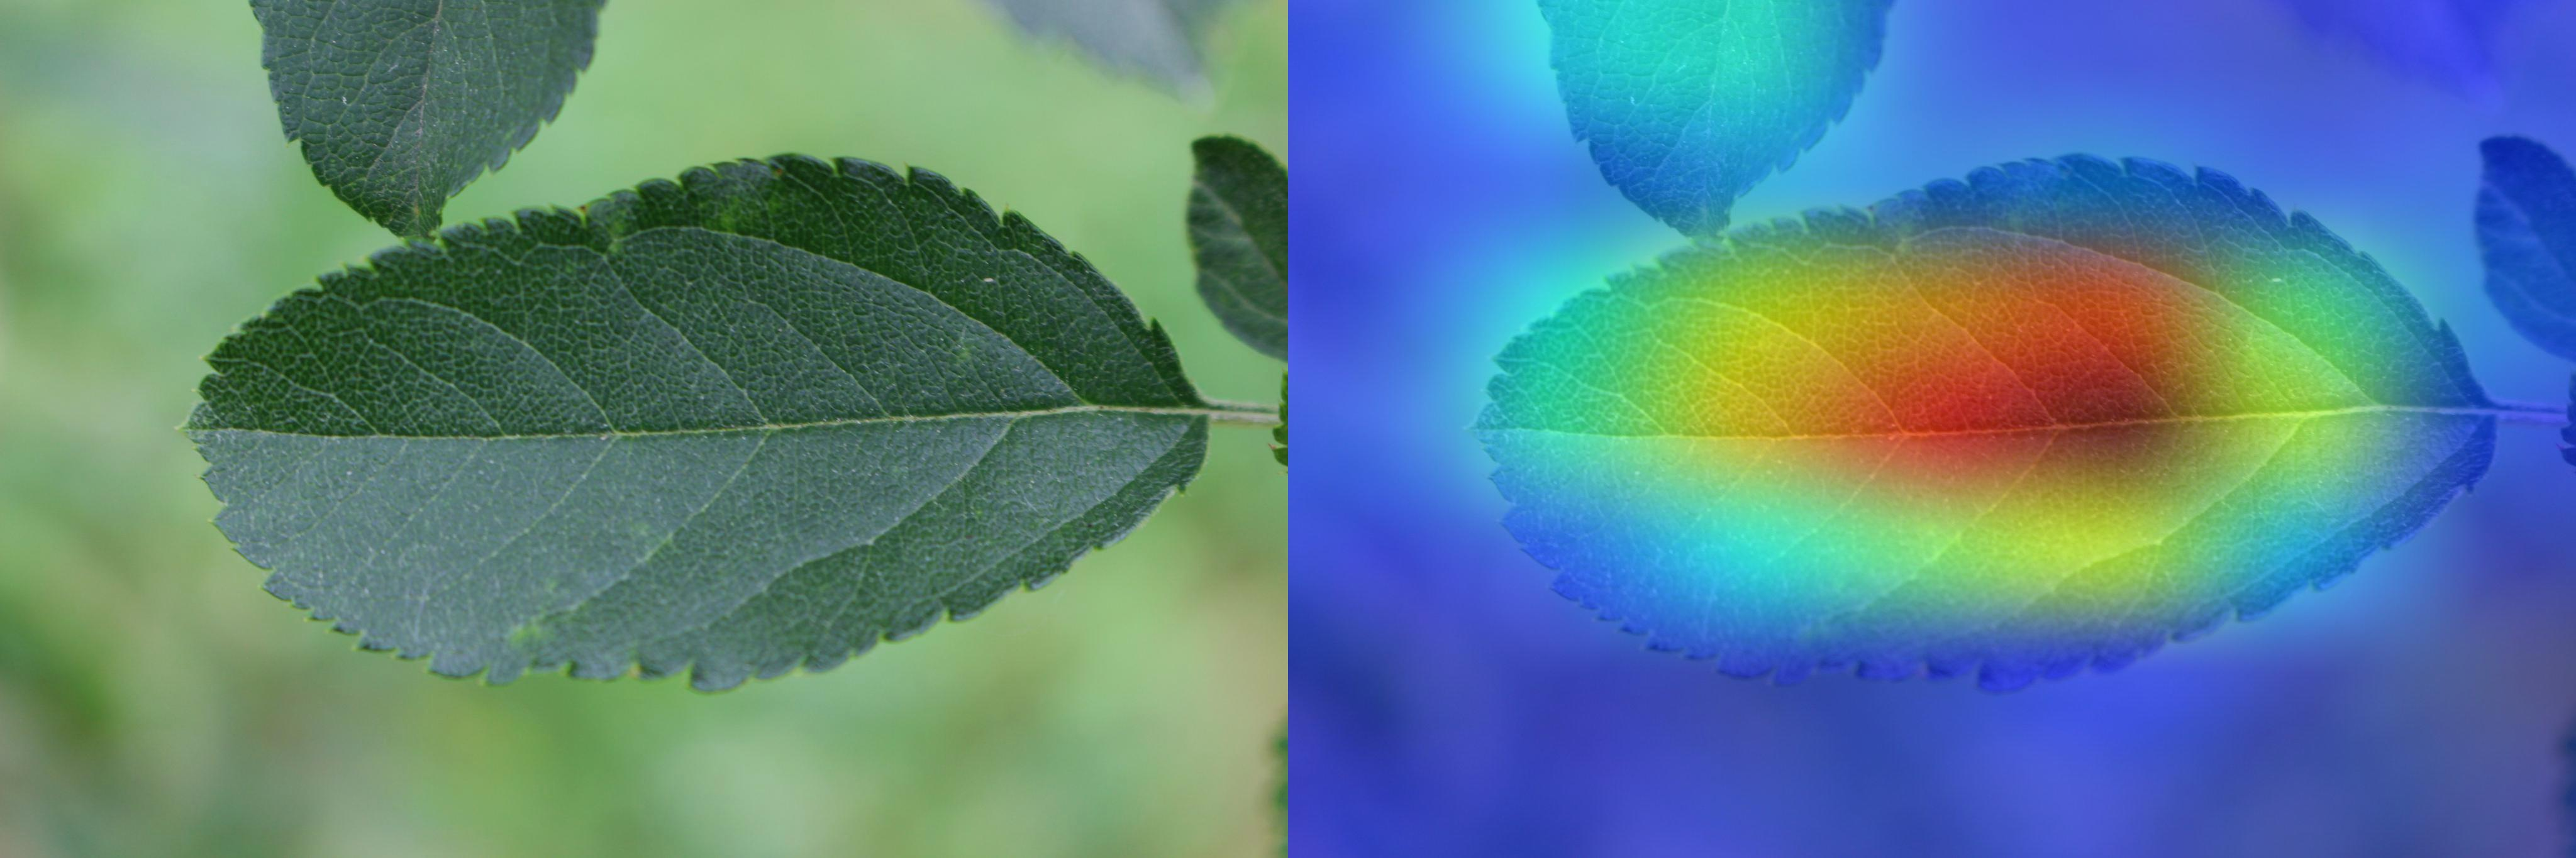

In [102]:
grad_cam.showGradCam(model2, img_path = r"F:\notebooks\capstone\data\fgvc7\images\Test_3.jpg")

Predicted: rust


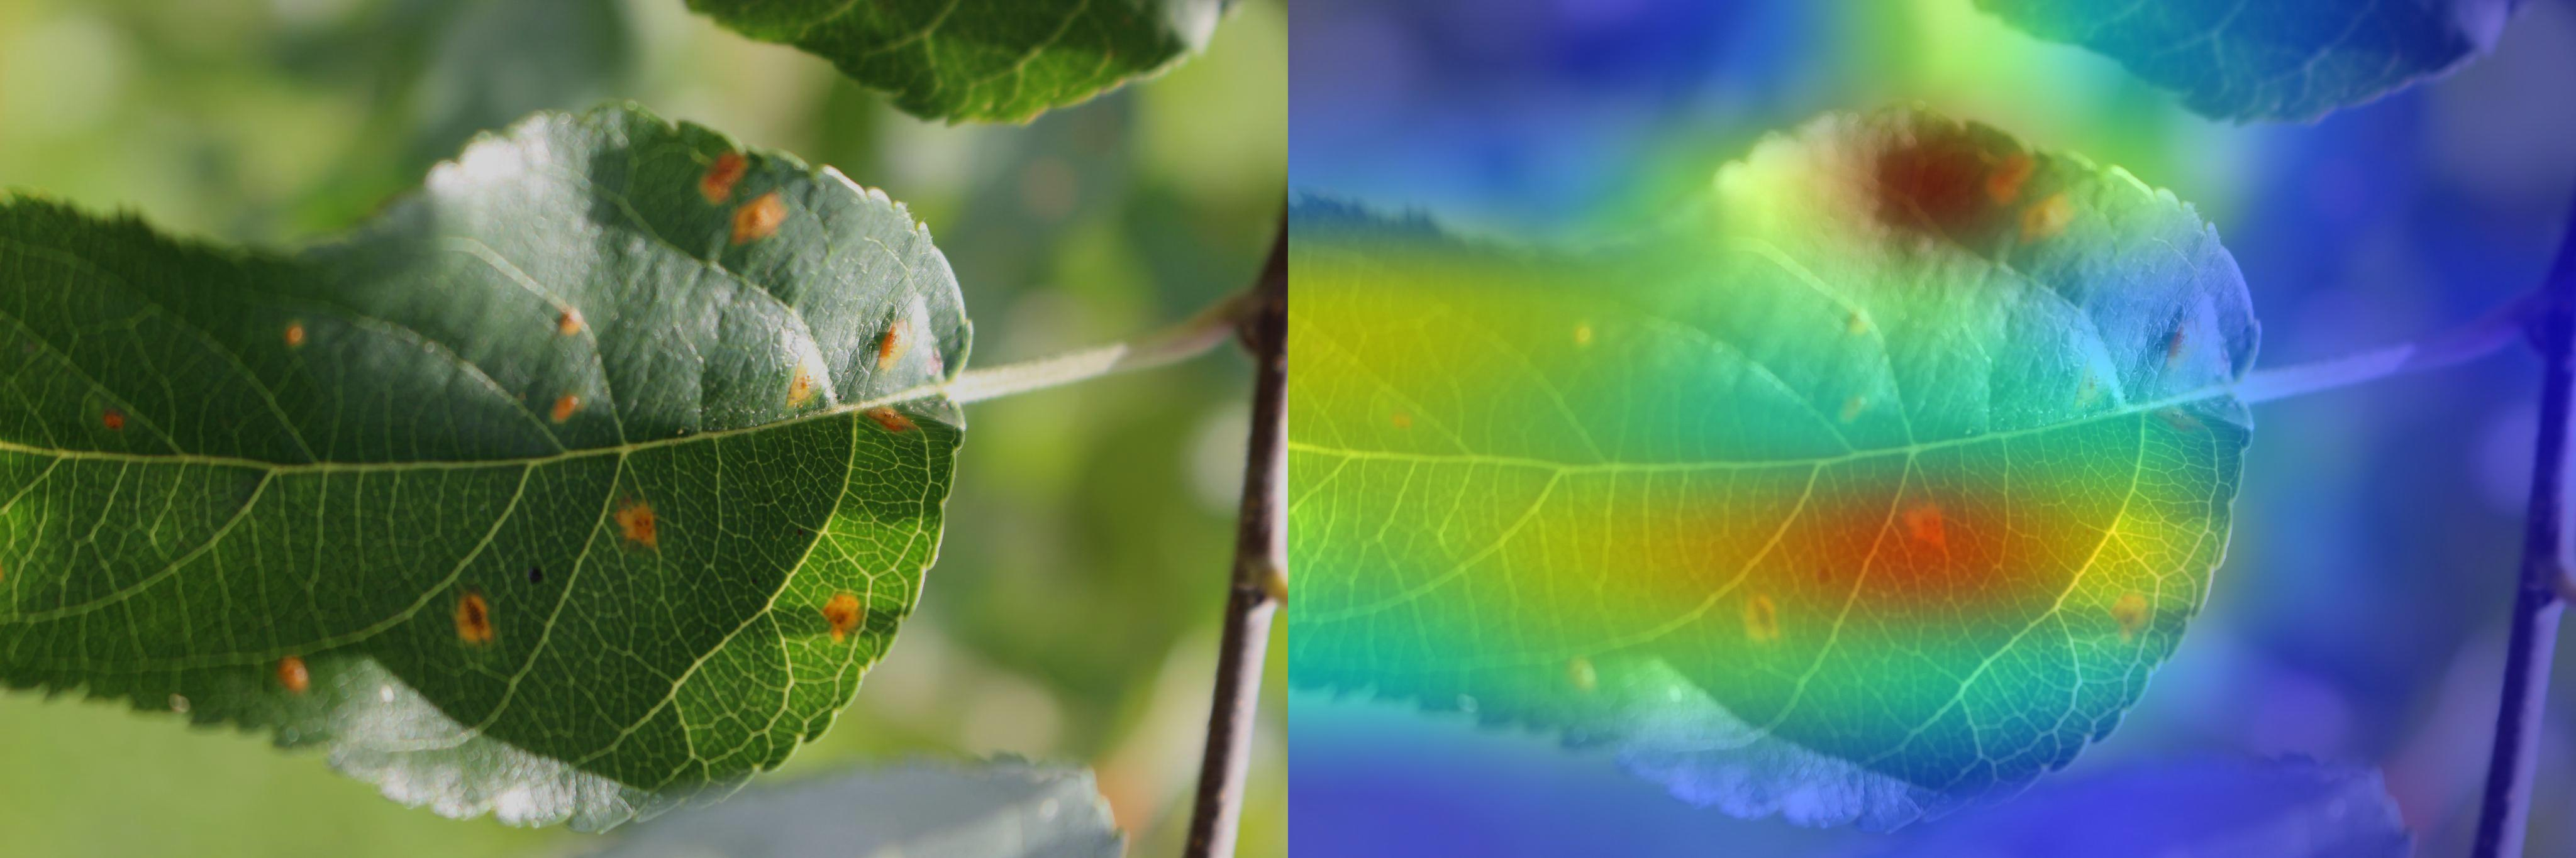

In [103]:
grad_cam.showGradCam(model2, img_path = r"F:\notebooks\capstone\data\fgvc7\images\Test_4.jpg")